In [1]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import random
import wandb  
from tqdm import tqdm

<h1> <b> Question 2 : Image classification

<h3> <b> Part 1

<b> <i>(a)

Label Class mappings

In [2]:
# Class label mapping:
label_map = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear': 4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

rollnumber seed

In [3]:
seed = 2021282
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

image paths and labels

In [4]:
data_dir = "russian-wildlife-dataset"  

all_image_paths = []
all_labels = []

for class_name, class_idx in label_map.items():
    class_folder = os.path.join(data_dir, class_name)
    
    
    images = glob.glob(os.path.join(class_folder, "*.*"))
    
    for img_path in images:
        all_image_paths.append(img_path)
        all_labels.append(class_idx)


all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)


random split

In [5]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


for train_index, val_index in splitter.split(all_image_paths, all_labels):
    train_paths, val_paths = all_image_paths[train_index], all_image_paths[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

custom dataset class

In [6]:
class RussianWildlifeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Open the image
        image = Image.open(img_path).convert("RGB")
        
        # Apply any transforms if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [7]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

wandb

In [8]:
wandb.login()  # you may need to log in with your API key once

wandb.init(
    project="russian-wildlife-classification",  # change project name as desired
    name="experiment-1",
    config={
        "batch_size": 32,
        "learning_rate": 0.001,
        "epochs": 10
    }
)

wandb: Currently logged in as: kartikeydhaka (kartikey_dhaka) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<b> <i> (b)

In [9]:
batch_size = 32

# Create Dataset objects
train_dataset = RussianWildlifeDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = RussianWildlifeDataset(val_paths,   val_labels,   transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)


<b> <i> (c) 

Visualise data distribution

In [10]:
import collections

train_label_counts = collections.Counter(train_labels)
val_label_counts   = collections.Counter(val_labels)

print("Training set distribution:")
for k, v in train_label_counts.items():
    print(f"Class {k} ({list(label_map.keys())[list(label_map.values()).index(k)]}): {v}")

print("\nValidation set distribution:")
for k, v in val_label_counts.items():
    print(f"Class {k} ({list(label_map.keys())[list(label_map.values()).index(k)]}): {v}")


Training set distribution:
Class 1 (amur_tiger): 839
Class 4 (brown_bear): 967
Class 2 (birds): 1157
Class 0 (amur_leopard): 783
Class 7 (sika_deer): 1231
Class 5 (dog): 970
Class 6 (roe_deer): 899
Class 3 (black_bear): 780
Class 8 (wild_boar): 1148
Class 9 (people): 560

Validation set distribution:
Class 1 (amur_tiger): 210
Class 6 (roe_deer): 225
Class 5 (dog): 243
Class 4 (brown_bear): 242
Class 0 (amur_leopard): 195
Class 7 (sika_deer): 308
Class 2 (birds): 289
Class 8 (wild_boar): 287
Class 9 (people): 140
Class 3 (black_bear): 195


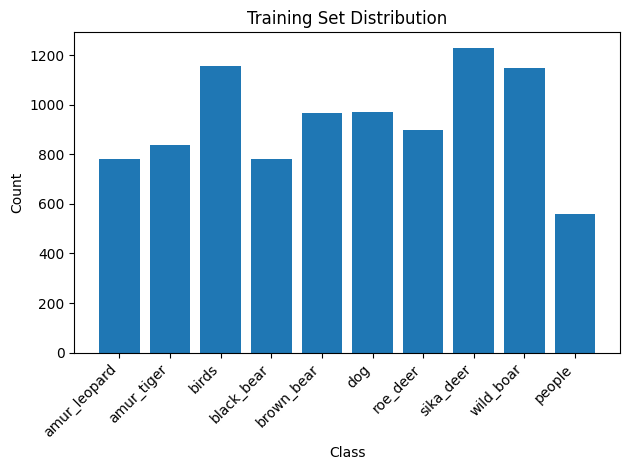

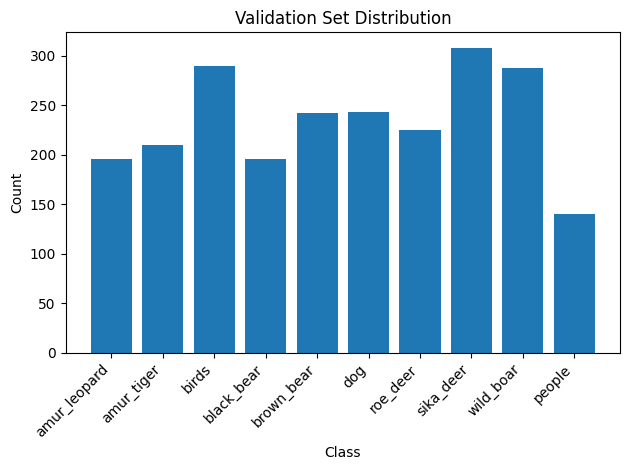

In [11]:
def plot_label_distribution(label_counts, title):
    classes = list(label_map.keys())
    counts = [label_counts[label_map[c]] for c in classes]  # order by class_map
    plt.bar(range(len(classes)), counts, tick_label=classes)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_label_distribution(train_label_counts, "Training Set Distribution")
plot_label_distribution(val_label_counts,   "Validation Set Distribution")


<h3> <b> Part 2

<b> <i> (a)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        # 1st Convolution Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,
                               stride=1, padding=1)
        # Max Pool (after 1st conv): kernel=4, stride=4
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        
        # 2nd Convolution Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                               stride=1, padding=1)
        # Max Pool (after 2nd conv): kernel=2, stride=2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 3rd Convolution Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,
                               stride=1, padding=1)
        # Max Pool (after 3rd conv): kernel=2, stride=2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Classification head
        # We'll flatten the output of pool3, then use a linear layer
        self.fc = nn.Linear(in_features=128 *  (224 // 4 // 2 // 2) * (224 // 4 // 2 // 2),
                            out_features=num_classes)
        # - Input image is 224x224
        # - After pool1 with kernel=4,stride=4 => 224/4=56
        # - After pool2 with kernel=2,stride=2 => 56/2=28
        # - After pool3 with kernel=2,stride=2 => 28/2=14
        # So final feature map is (128, 14, 14). Flatten => 128*14*14

    def forward(self, x):
        # 1st conv + ReLU + max pool
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # 2nd conv + ReLU + max pool
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # 3rd conv + ReLU + max pool
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classification layer
        x = self.fc(x)
        return x


training setup

<b> <i> (b)

In [12]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'


import torch.optim as optim

model = ConvNet(num_classes=10)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # adds label smoothing
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, 
                                          steps_per_epoch=len(train_loader),
                                          epochs=50) 

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    
    # Wrap your training DataLoader with tqdm
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        # Optionally update the description or postfix of tqdm
        current_loss = running_loss / total_samples
        current_acc = correct_preds / total_samples
        train_pbar.set_postfix({"loss": f"{current_loss:.4f}",
                                "acc": f"{current_acc:.4f}"})

    train_epoch_loss = running_loss / total_samples
    train_epoch_acc = correct_preds / total_samples
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_samples = 0
    
    # Wrap validation DataLoader with tqdm
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    with torch.no_grad():
        for val_images, val_labels in val_pbar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item() * val_images.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct_preds += (val_predicted == val_labels).sum().item()
            val_total_samples += val_labels.size(0)
            
            current_val_loss = val_running_loss / val_total_samples
            current_val_acc = val_correct_preds / val_total_samples
            val_pbar.set_postfix({"loss": f"{current_val_loss:.4f}",
                                  "acc": f"{current_val_acc:.4f}"})
    
    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_correct_preds / val_total_samples
    
    # Log metrics to wandb
    wandb.log({
        "Epoch": epoch+1,
        "Train Loss": train_epoch_loss,
        "Train Accuracy": train_epoch_acc,
        "Validation Loss": val_epoch_loss,
        "Validation Accuracy": val_epoch_acc
    })
    
    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


Epoch 1/10 [Train]:   2%|▏         | 6/292 [00:00<00:29,  9.65it/s, loss=2.2805, acc=0.1562]

Epoch 1/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.69it/s, loss=1.9416, acc=0.3569]


[Epoch 1/10] Train Loss: 2.0904, Train Acc: 0.2744 | Val Loss: 1.9416, Val Acc: 0.3569


Epoch 2/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 12.16it/s, loss=1.8011, acc=0.4173]


[Epoch 2/10] Train Loss: 1.8604, Train Acc: 0.3930 | Val Loss: 1.8011, Val Acc: 0.4173


Epoch 3/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.87it/s, loss=1.6848, acc=0.4584]


[Epoch 3/10] Train Loss: 1.7292, Train Acc: 0.4681 | Val Loss: 1.6848, Val Acc: 0.4584


Epoch 4/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.47it/s, loss=1.5869, acc=0.5347]


[Epoch 4/10] Train Loss: 1.6193, Train Acc: 0.5170 | Val Loss: 1.5869, Val Acc: 0.5347


Epoch 5/10 [Val]: 100%|██████████| 73/73 [00:05<00:00, 12.62it/s, loss=1.5978, acc=0.5193]


[Epoch 5/10] Train Loss: 1.5493, Train Acc: 0.5519 | Val Loss: 1.5978, Val Acc: 0.5193


Epoch 6/10 [Val]: 100%|██████████| 73/73 [00:05<00:00, 12.29it/s, loss=1.4866, acc=0.5797]


[Epoch 6/10] Train Loss: 1.4530, Train Acc: 0.5959 | Val Loss: 1.4866, Val Acc: 0.5797


Epoch 7/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.38it/s, loss=1.4679, acc=0.6028]


[Epoch 7/10] Train Loss: 1.3885, Train Acc: 0.6256 | Val Loss: 1.4679, Val Acc: 0.6028


Epoch 8/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.50it/s, loss=1.4045, acc=0.6093]


[Epoch 8/10] Train Loss: 1.3172, Train Acc: 0.6606 | Val Loss: 1.4045, Val Acc: 0.6093


Epoch 9/10 [Val]: 100%|██████████| 73/73 [00:05<00:00, 12.36it/s, loss=1.4025, acc=0.6050]


[Epoch 9/10] Train Loss: 1.2663, Train Acc: 0.6856 | Val Loss: 1.4025, Val Acc: 0.6050


Epoch 10/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.25it/s, loss=1.3648, acc=0.6495]


[Epoch 10/10] Train Loss: 1.1958, Train Acc: 0.7196 | Val Loss: 1.3648, Val Acc: 0.6495


In [13]:
torch.save(model.state_dict(), 'convnet.pth')

<b> <i> (c)

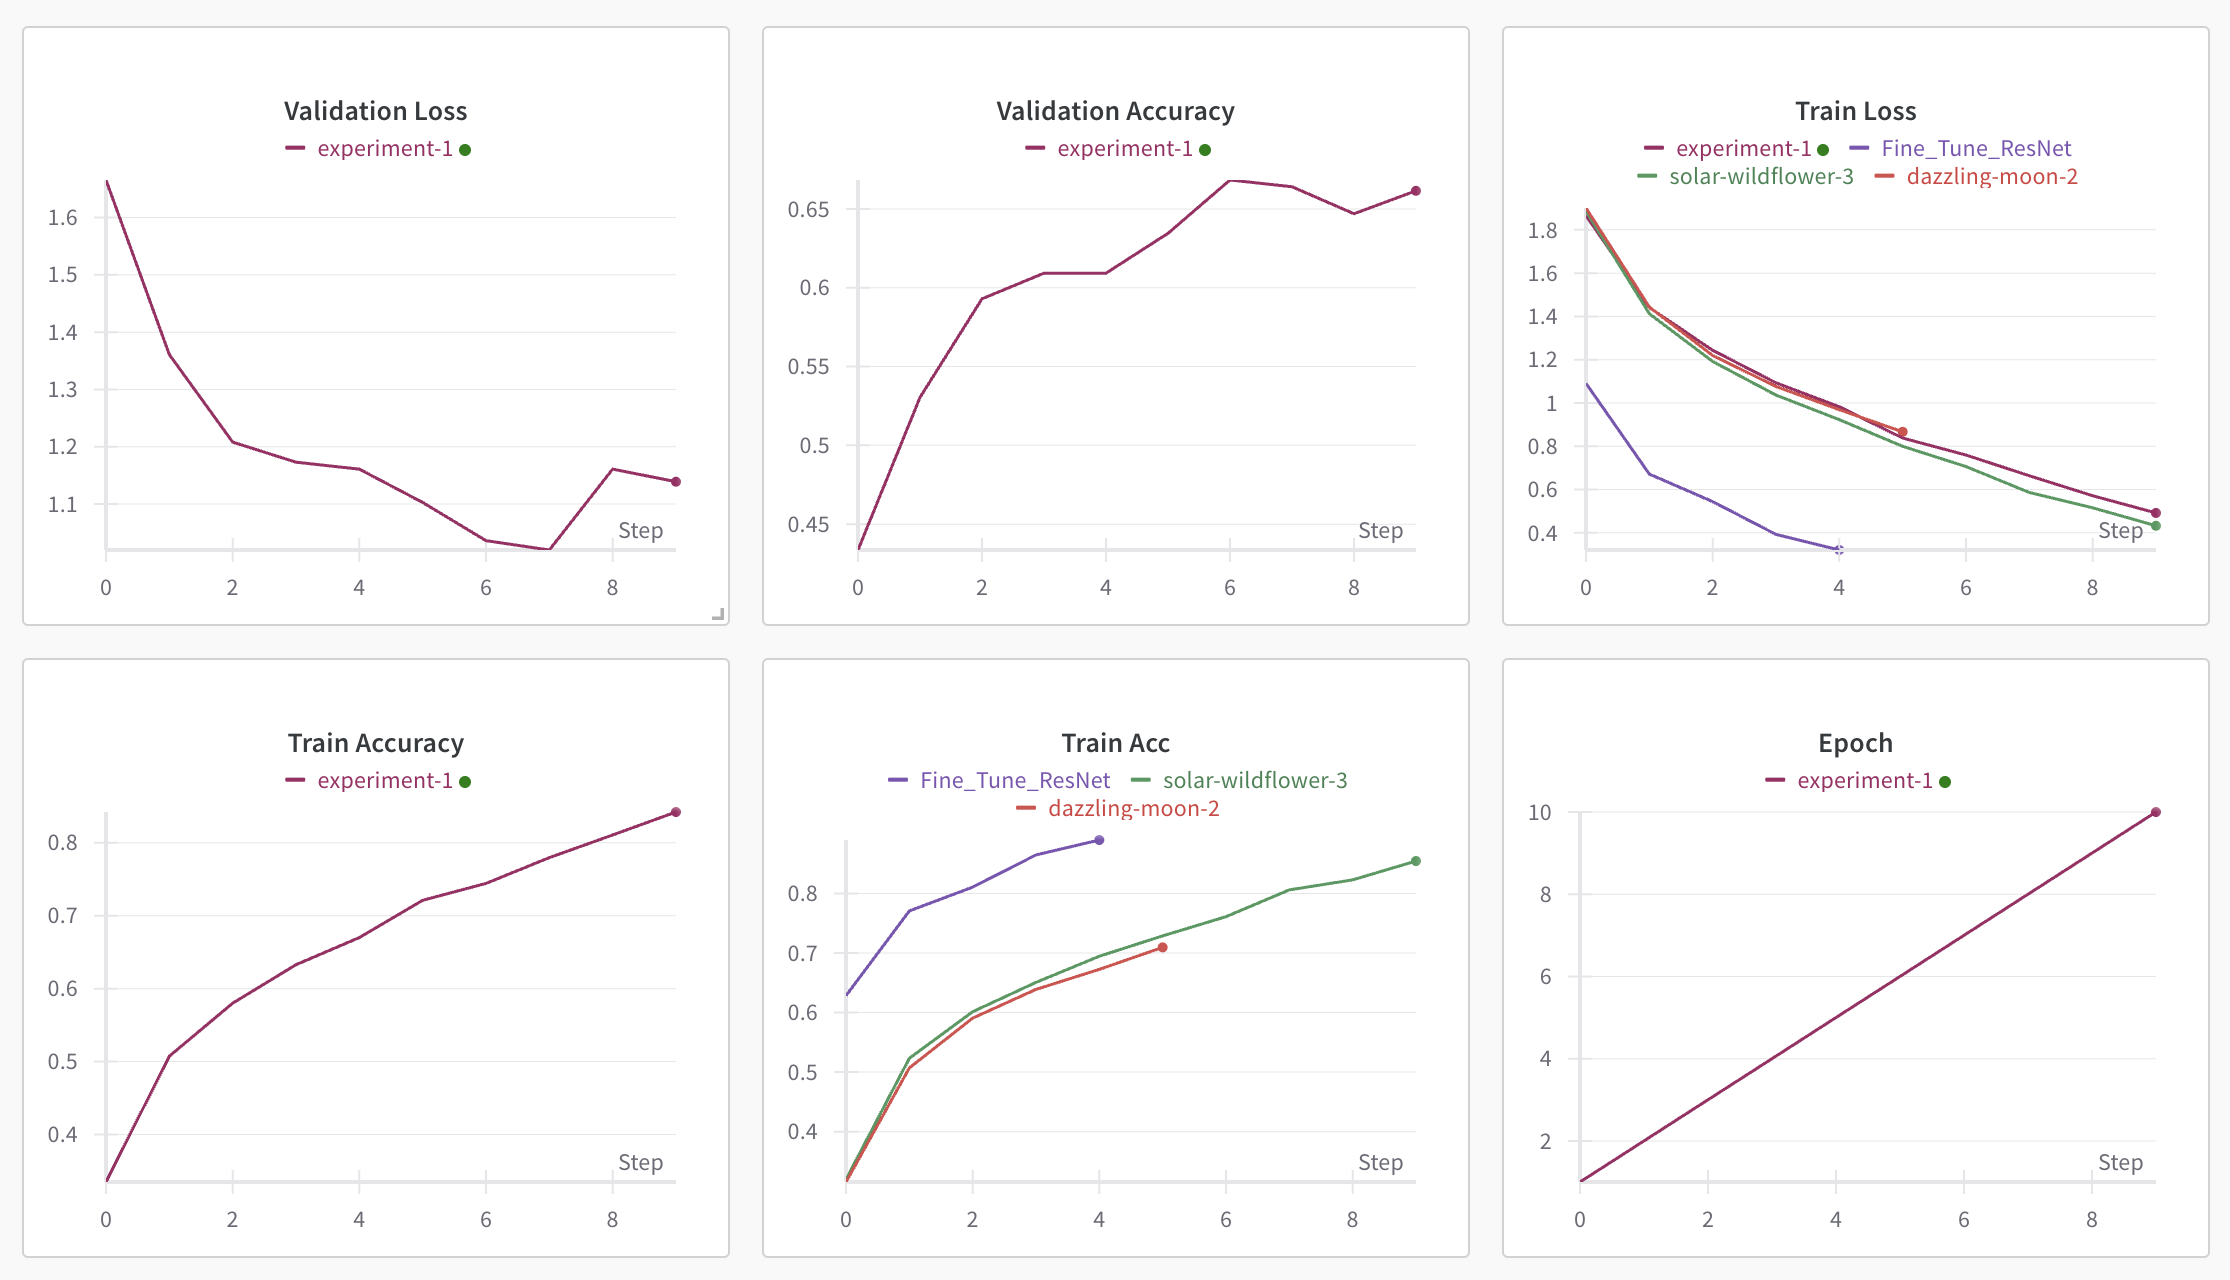

We observe that after epoch 7, the training loss continues to decrease, but validation loss begins to rise. This suggests the model starts to overfit around epoch 7

<b> <i> (d)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

model.eval()
val_preds = []
val_targets = []

with torch.no_grad():
    for val_images, val_labels in val_loader:
        val_images = val_images.to(device='cuda' if torch.cuda.is_available() else 'cpu')
        val_labels = val_labels.to(device='cuda' if torch.cuda.is_available() else 'cpu')
        
        outputs = model(val_images)
        _, predicted = torch.max(outputs, 1)
        
        val_preds.extend(predicted.cpu().numpy())
        val_targets.extend(val_labels.cpu().numpy())

val_accuracy = accuracy_score(val_targets, val_preds)
val_f1 = f1_score(val_targets, val_preds, average='macro')  # or 'weighted'

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

# Log to wandb
wandb.log({
    "Final Validation Accuracy": val_accuracy,
    "Final Validation F1": val_f1
})

# Confusion matrix
cm = confusion_matrix(val_targets, val_preds)
print("Confusion Matrix:\n", cm)


wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                           y_true=val_targets,
                                                           preds=val_preds,
                                                           class_names=list(label_map.keys()))})


Validation Accuracy: 0.6615
Validation F1-Score: 0.6623
Confusion Matrix:
 [[133  20   8   2   4  11   4   6   0   7]
 [ 19 119  13   2   7  19   6  16   2   7]
 [  4   7 226   4   3  18   3   9   3  12]
 [  0   1   2 114  50   5   3   4  14   2]
 [  2   2   7  35 164   7   7   8   8   2]
 [  3   1  11   9  19 154  12  19   3  12]
 [  0   5   4   0   8  23 137  37   5   6]
 [  2   6  17   8  20  22  31 177   9  16]
 [  0   1   3  14  24  15   6  12 207   5]
 [  1   1   6   1   2  11   0   5   0 113]]


<b> <i> wandb visualisation:

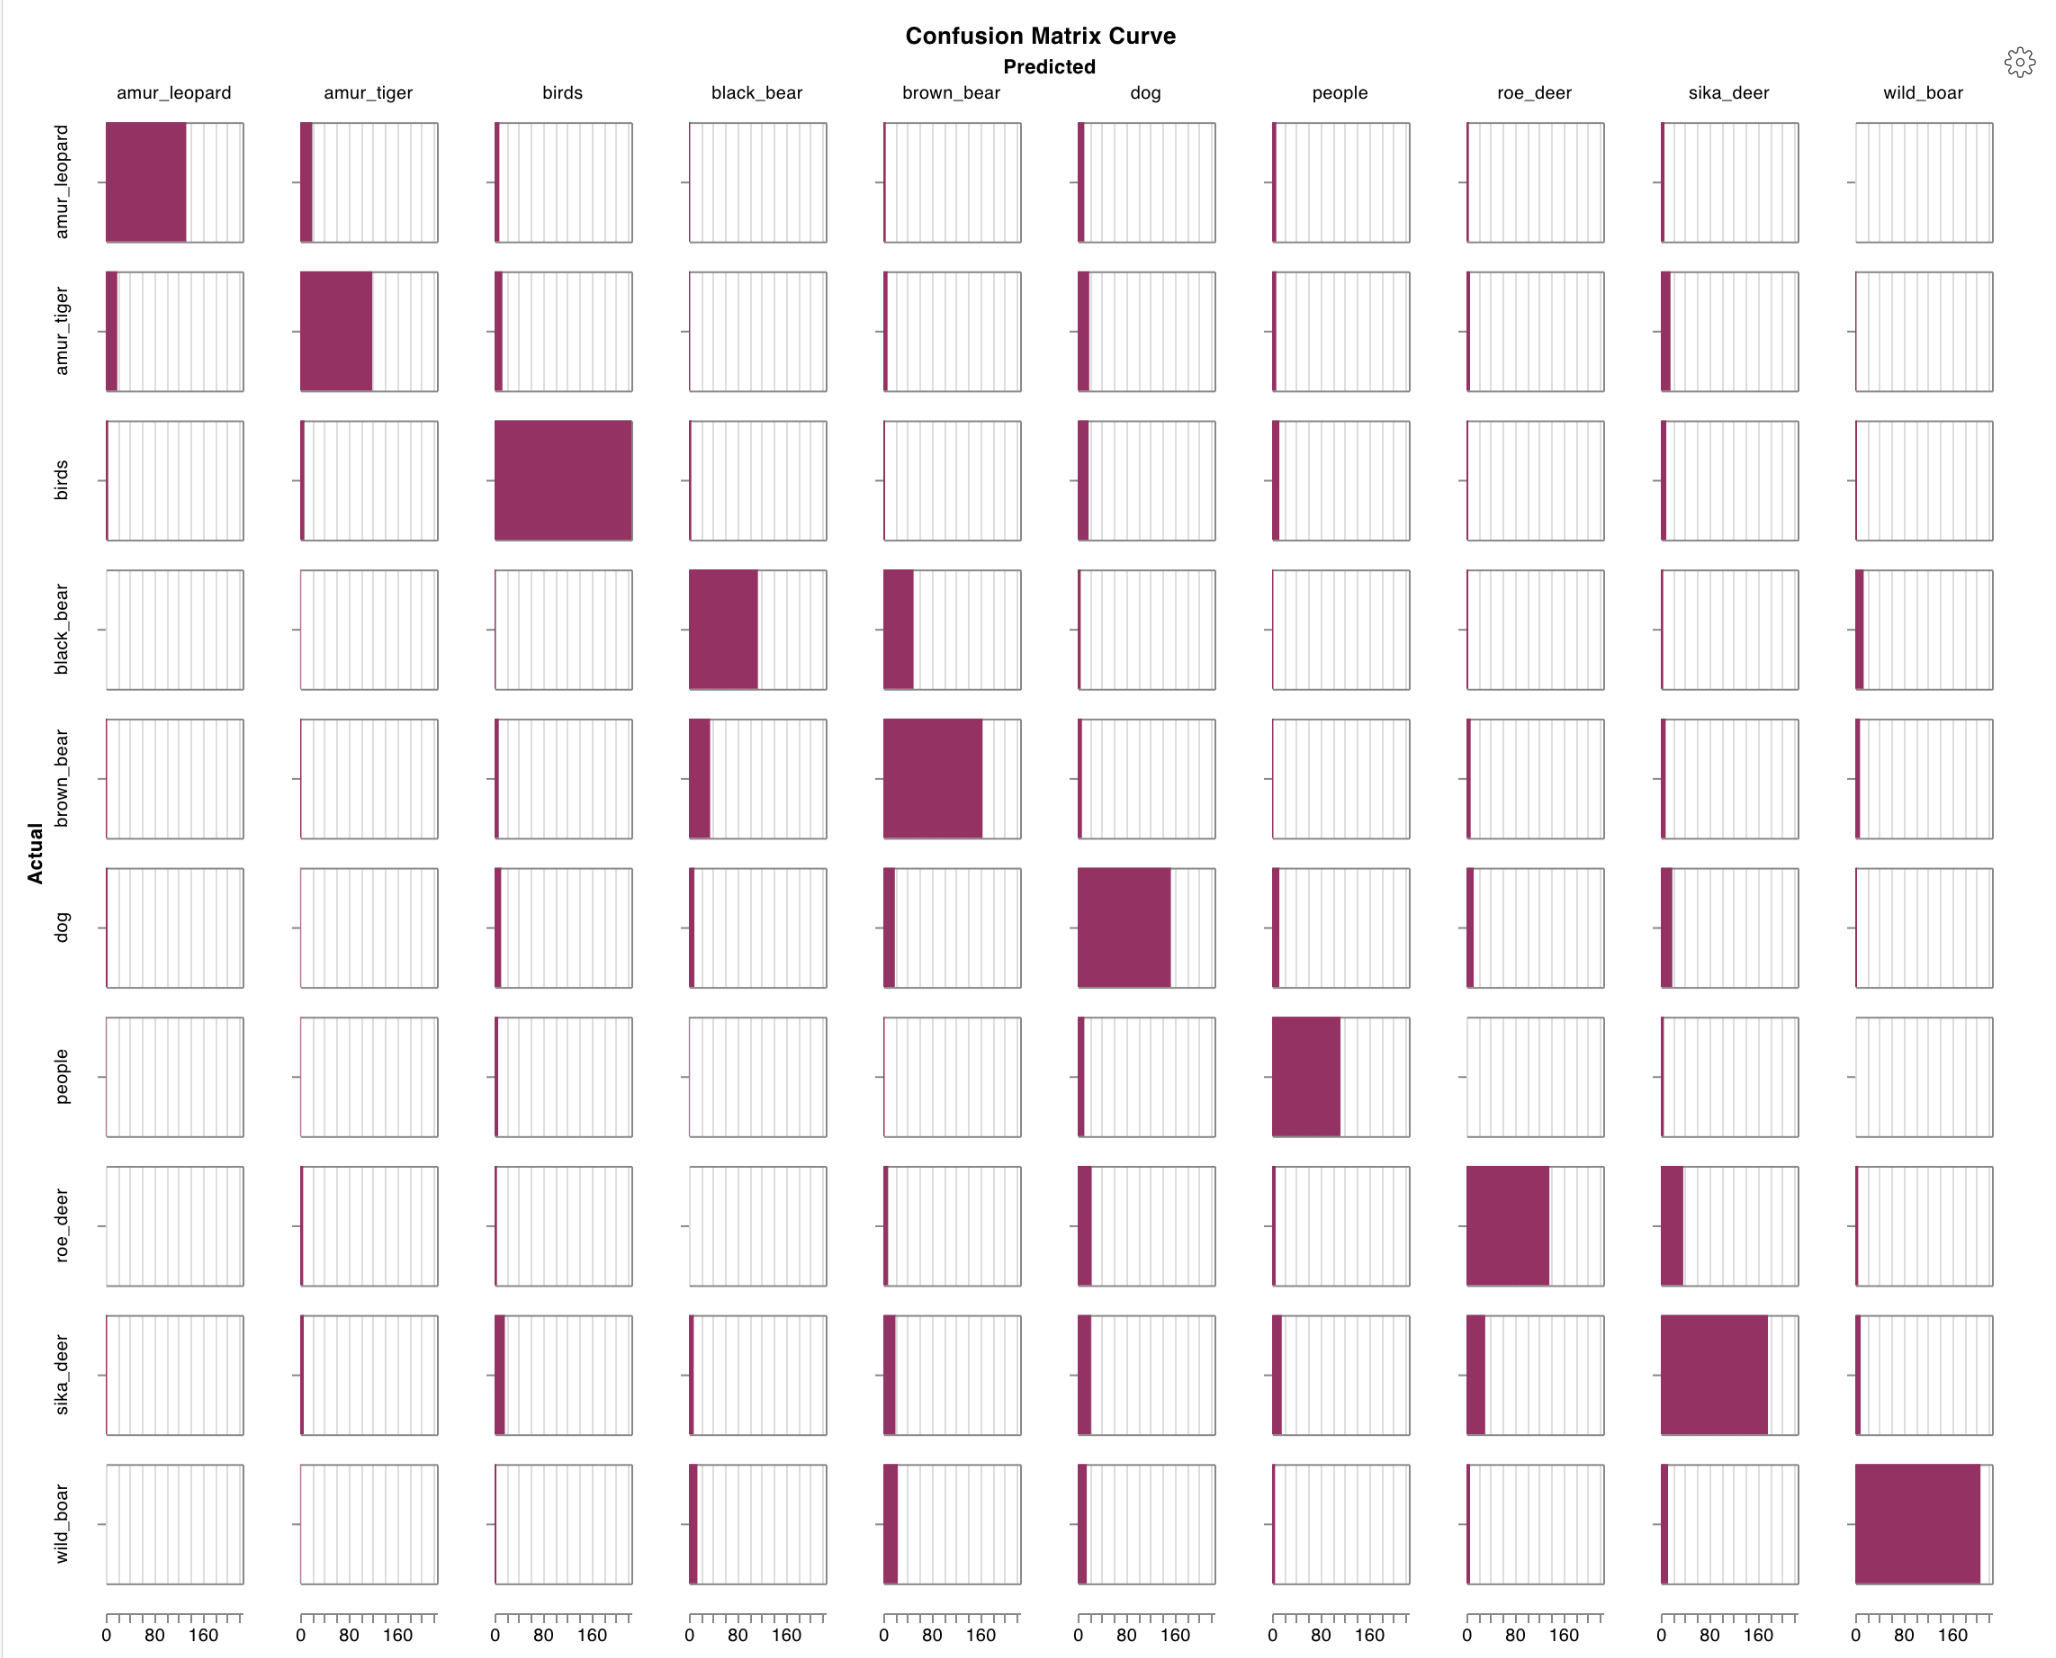

<b> <i> (e)

In [17]:
import collections

val_images_list = []
val_labels_list = []
val_preds_list  = []

model.eval()
with torch.no_grad():
    for val_images, val_labels in val_loader:
        val_images = val_images.to(device='cuda' if torch.cuda.is_available() else 'cpu')
        val_labels = val_labels.to(device='cuda' if torch.cuda.is_available() else 'cpu')
        
        outputs = model(val_images)
        _, predicted = torch.max(outputs, 1)

        # move to CPU numpy
        val_images_list.extend(val_images.cpu().numpy())
        val_labels_list.extend(val_labels.cpu().numpy())
        val_preds_list.extend(predicted.cpu().numpy())
        
val_images_list = np.array(val_images_list)
val_labels_list = np.array(val_labels_list)
val_preds_list  = np.array(val_preds_list)

misclassified_indices = np.where(val_labels_list != val_preds_list)[0]
print(f"Total misclassifications: {len(misclassified_indices)}")

# Group misclassifications by true label
from collections import defaultdict
misclassified_dict = defaultdict(list)

for idx in misclassified_indices:
    true_lbl = val_labels_list[idx]
    misclassified_dict[true_lbl].append(idx)


Total misclassifications: 790


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


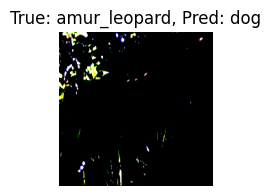

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.64].


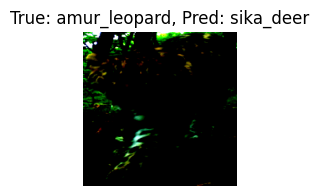

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


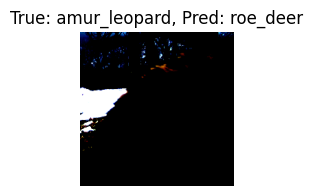

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..0.62535024].


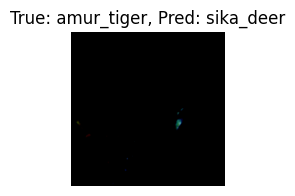

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..0.15968838].


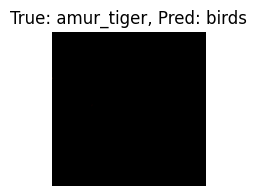

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.64].


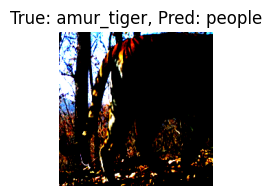

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7347276..2.64].


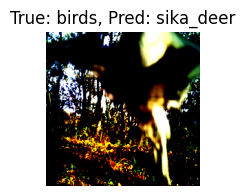

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


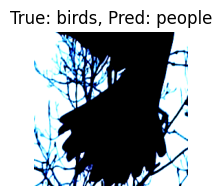

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.8858544].


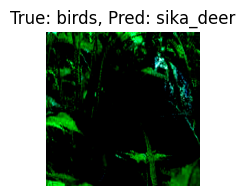

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.5877128].


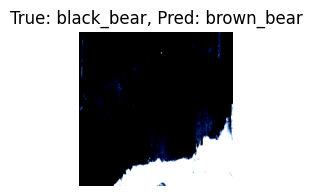

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702832].


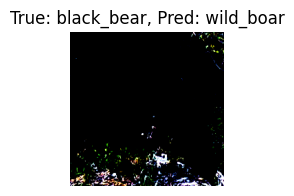

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..0.74021804].


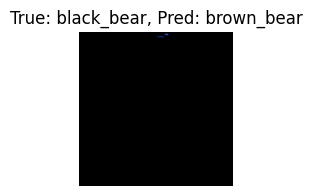

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4329139..0.98422676].


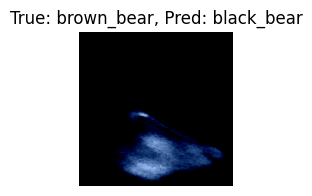

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.5005665].


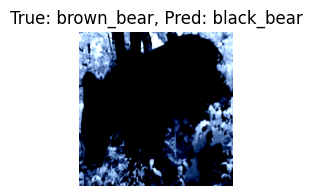

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2914162].


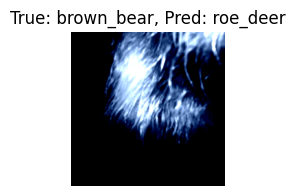

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4500387..1.733682].


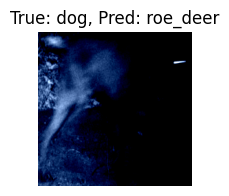

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.3088455].


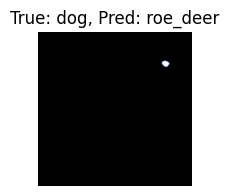

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.9428324].


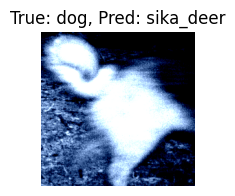

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.64].


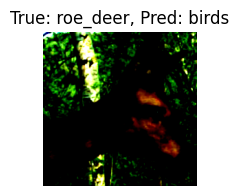

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.235994].


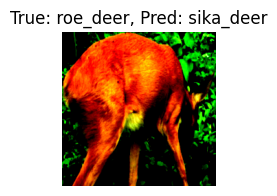

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..1.9920369].


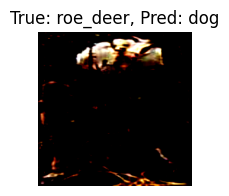

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.3262744].


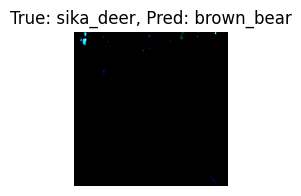

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.4285715].


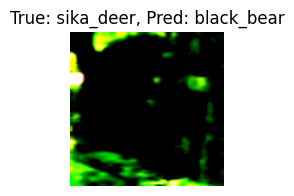

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.0776608].


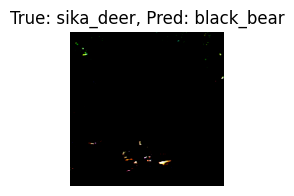

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9020464..1.2979523].


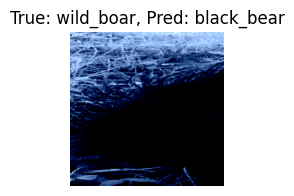

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81642264..2.64].


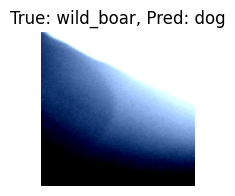

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.83543426].


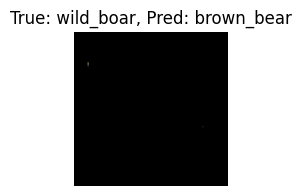

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


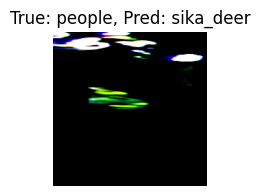

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.622571].


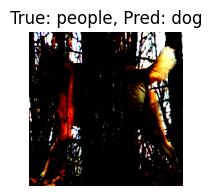

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.5877128].


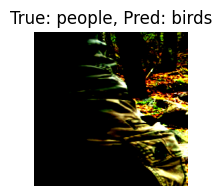

In [18]:
import matplotlib.pyplot as plt

# For each class (0 to 9), pick up to 3 misclassified samples
for class_idx in range(10):
    if class_idx in misclassified_dict:
        sample_indices = misclassified_dict[class_idx][:3]  # get up to 3 indices
        
        for i, mis_idx in enumerate(sample_indices):
            image_tensor = val_images_list[mis_idx]  # shape [C,H,W] as numpy
            predicted_label = val_preds_list[mis_idx]
            
            # Convert tensor-like (C,H,W) to (H,W,C) for matplotlib
            image_for_plot = np.transpose(image_tensor, (1, 2, 0))
            
            # Undo normalization if you used it
            # e.g., if mean=[0.485,0.456,0.406] and std=[0.229,0.224,0.225],
            # you might want to do: image_for_plot = std * image_for_plot + mean
            # Then clip to [0,1]
            
            plt.figure(figsize=(2,2))
            plt.imshow(image_for_plot)
            plt.title(f"True: {list(label_map.keys())[class_idx]}, Pred: {list(label_map.keys())[predicted_label]}")
            plt.axis("off")
            plt.show()


why the model failed:

The image might not clearly show the ground-truth class (e.g., partial or occluded).
The image could look visually similar to another class (e.g., “brown_bear” vs. “black_bear” in poor lighting).
The model might be undertrained or lacks certain augmentations.

Possible workarounds:

More/better data (especially if certain classes are underrepresented).
Data augmentations (rotation, color jitter, etc.) to help the model generalize.
Use a more powerful architecture or transfer learning from a pre-trained model.
Improve hyperparameter tuning (learning rate, batch size, weight decay).

<h3> <b> Part 3 

<b> <i> (a)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

# 1. Load Pretrained ResNet-18
resnet18 = models.resnet18(pretrained=True)  # or use weights=models.ResNet18_Weights.IMAGENET1K_V1 (newer PyTorch)
num_features = resnet18.fc.in_features

# 2. Modify the final FC layer to match your 10 classes
resnet18.fc = nn.Linear(num_features, 10)

# 3. Decide if you want to fine-tune all layers or only some:
#    By default, if you do *not* freeze anything, all layers are trainable.
#    Example to freeze "early" layers: 
# for name, param in resnet18.named_parameters():
#     if "layer4" not in name and "fc" not in name:
#         param.requires_grad = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet18 = resnet18.to(device)

# Example transforms (reuse from Part 2 or adapt)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 4. Reuse your custom Dataset from Part 1
# from your_dataset_file import RussianWildlifeDataset (if you put it in a separate file)
# Or define it here again.

# Then create Datasets & DataLoaders (train_loader & val_loader)
# train_dataset = RussianWildlifeDataset(train_paths, train_labels, transform=train_transform)
# val_dataset   = RussianWildlifeDataset(val_paths, val_labels, transform=val_transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 5. Initialize wandb
wandb.login()
wandb.init(project="russian-wildlife-resnet18", name="fine-tune-resnet18",
           config={"epochs": 10, "batch_size": 32, "lr": 1e-3})

# 6. Set up optimizer & loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=1e-3)

# 7. Training Loop (10 epochs, or more)
num_epochs = wandb.config.epochs

for epoch in range(num_epochs):
    resnet18.train()
    running_loss, correct, total = 0.0, 0, 0
    
    # Training
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        train_pbar.set_postfix({"loss": f"{running_loss/total:.4f}",
                                "acc": f"{correct/total:.4f}"})
        
    train_epoch_loss = running_loss / total
    train_epoch_acc  = correct / total

    # Validation
    resnet18.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, val_preds = torch.max(outputs, 1)
            val_correct += (val_preds == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({"val_loss": f"{val_loss/val_total:.4f}",
                                  "val_acc":  f"{val_correct/val_total:.4f}"})
            
    val_epoch_loss = val_loss / val_total
    val_epoch_acc  = val_correct / val_total
    
    # 8. Log to wandb
    wandb.log({
        "epoch": epoch+1,
        "train_loss": train_epoch_loss,
        "train_acc": train_epoch_acc,
        "val_loss": val_epoch_loss,
        "val_acc": val_epoch_acc
    })
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


/mnt/drive/home/pragyas/anaconda3/envs/cva1/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/drive/home/pragyas/anaconda3/envs/cva1/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
Epoch 1/10 [Train]:   3%|▎         | 10/292 [00:01<00:25, 11.00it/s, loss=1.8262, acc=0.4031]

Epoch 1/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.22it/s, val_loss=0.8779, val_acc=0.7022]


Epoch [1/10] Train Loss: 1.0732, Train Acc: 0.6332 | Val Loss: 0.8779, Val Acc: 0.7022


Epoch 2/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 12.08it/s, val_loss=0.6894, val_acc=0.7656]


Epoch [2/10] Train Loss: 0.7138, Train Acc: 0.7535 | Val Loss: 0.6894, Val Acc: 0.7656


Epoch 3/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.64it/s, val_loss=0.7032, val_acc=0.7485]


Epoch [3/10] Train Loss: 0.5721, Train Acc: 0.8002 | Val Loss: 0.7032, Val Acc: 0.7485


Epoch 4/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.21it/s, val_loss=0.5573, val_acc=0.8153]


Epoch [4/10] Train Loss: 0.5019, Train Acc: 0.8269 | Val Loss: 0.5573, Val Acc: 0.8153


Epoch 5/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.81it/s, val_loss=0.4455, val_acc=0.8398]


Epoch [5/10] Train Loss: 0.3950, Train Acc: 0.8636 | Val Loss: 0.4455, Val Acc: 0.8398


Epoch 6/10 [Val]: 100%|██████████| 73/73 [00:05<00:00, 12.51it/s, val_loss=0.4810, val_acc=0.8350]


Epoch [6/10] Train Loss: 0.3410, Train Acc: 0.8847 | Val Loss: 0.4810, Val Acc: 0.8350


Epoch 7/10 [Val]: 100%|██████████| 73/73 [00:05<00:00, 12.33it/s, val_loss=0.5438, val_acc=0.8243]


Epoch [7/10] Train Loss: 0.3405, Train Acc: 0.8808 | Val Loss: 0.5438, Val Acc: 0.8243


Epoch 8/10 [Val]: 100%|██████████| 73/73 [00:05<00:00, 12.24it/s, val_loss=0.6249, val_acc=0.8098]


Epoch [8/10] Train Loss: 0.2579, Train Acc: 0.9117 | Val Loss: 0.6249, Val Acc: 0.8098


Epoch 9/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.31it/s, val_loss=0.5676, val_acc=0.8256]


Epoch [9/10] Train Loss: 0.2259, Train Acc: 0.9240 | Val Loss: 0.5676, Val Acc: 0.8256


Epoch 10/10 [Val]: 100%|██████████| 73/73 [00:06<00:00, 11.30it/s, val_loss=0.7678, val_acc=0.7836]


Epoch [10/10] Train Loss: 0.2150, Train Acc: 0.9265 | Val Loss: 0.7678, Val Acc: 0.7836


In [13]:
torch.save(resnet18.state_dict(), 'resnet.pth')

<b> <i> (b) 

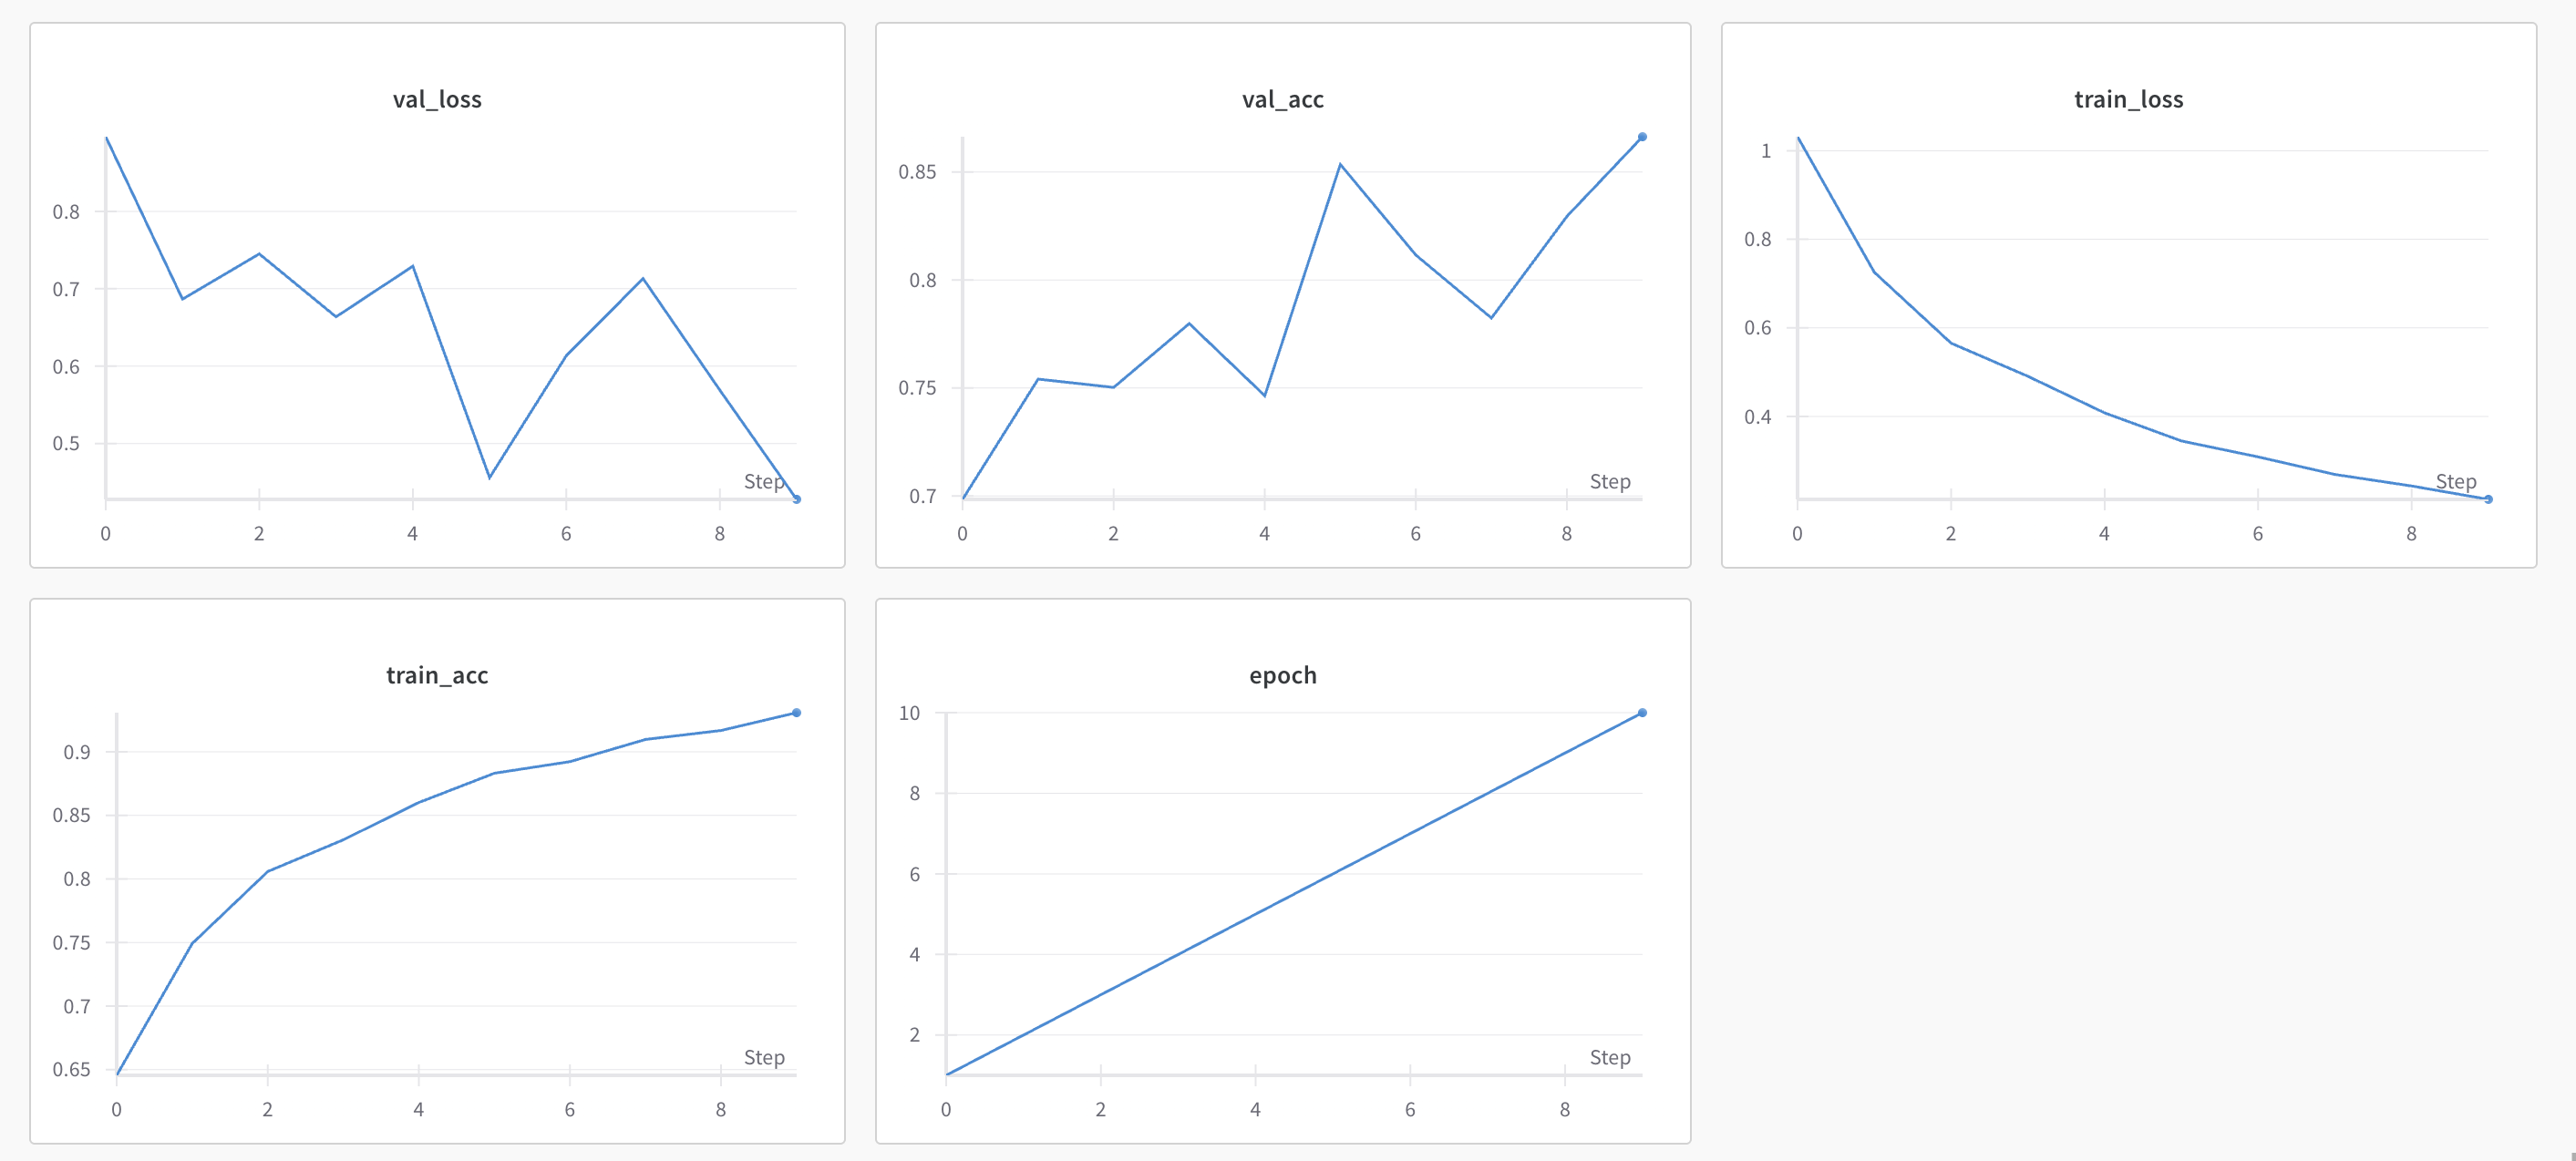

From the plots:

- **Training loss** steadily decreases and training accuracy rises close to 90%+ by the final epoch.  
- **Validation loss** also trends downward overall (despite a little fluctuation) and validation accuracy climbs toward ~90%.  

Because both training and validation curves improve (i.e., *both* losses decline and *both* accuracies rise) and do not diverge significantly, there is **no strong sign of overfitting**. The model is fitting the training set *and* continuing to generalize well on the validation set. If you notice the validation loss and accuracy flatten or degrade in later epochs while training performance continues to improve, *that* would indicate overfitting—but based on these curves, the model is currently *not* overfitting in a problematic way.

<b> <i> (c) 

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

resnet18.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds, average='macro')  # or 'weighted'
cm = confusion_matrix(all_labels, all_preds)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:")
print(cm)

# log to wandb
wandb.log({"Final Val Accuracy": val_accuracy,
           "Final Val F1": val_f1})

# confusion matrix plot
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                           y_true=all_labels,
                                                           preds=all_preds,
                                                           class_names=list(label_map.keys()))})


Validation Accuracy: 0.8663
Validation F1 Score: 0.8708
Confusion Matrix:
[[190   2   1   0   0   1   1   0   0   0]
 [  3 191   2   0   2   5   1   4   1   1]
 [  1   2 251   2   4  16   3   5   3   2]
 [  0   0   1 165  23   0   1   0   5   0]
 [  0   0   2  28 194   1   5   1   9   2]
 [  0   0   5   1   4 203  20   4   2   4]
 [  1   0   1   0   0   4 211   6   1   1]
 [  1   2  10   0   8   2  45 230   7   3]
 [  1   1   2   7   2   5   3   7 258   1]
 [  0   0   2   1   3   4   0   1   0 129]]


wandb visualisation:

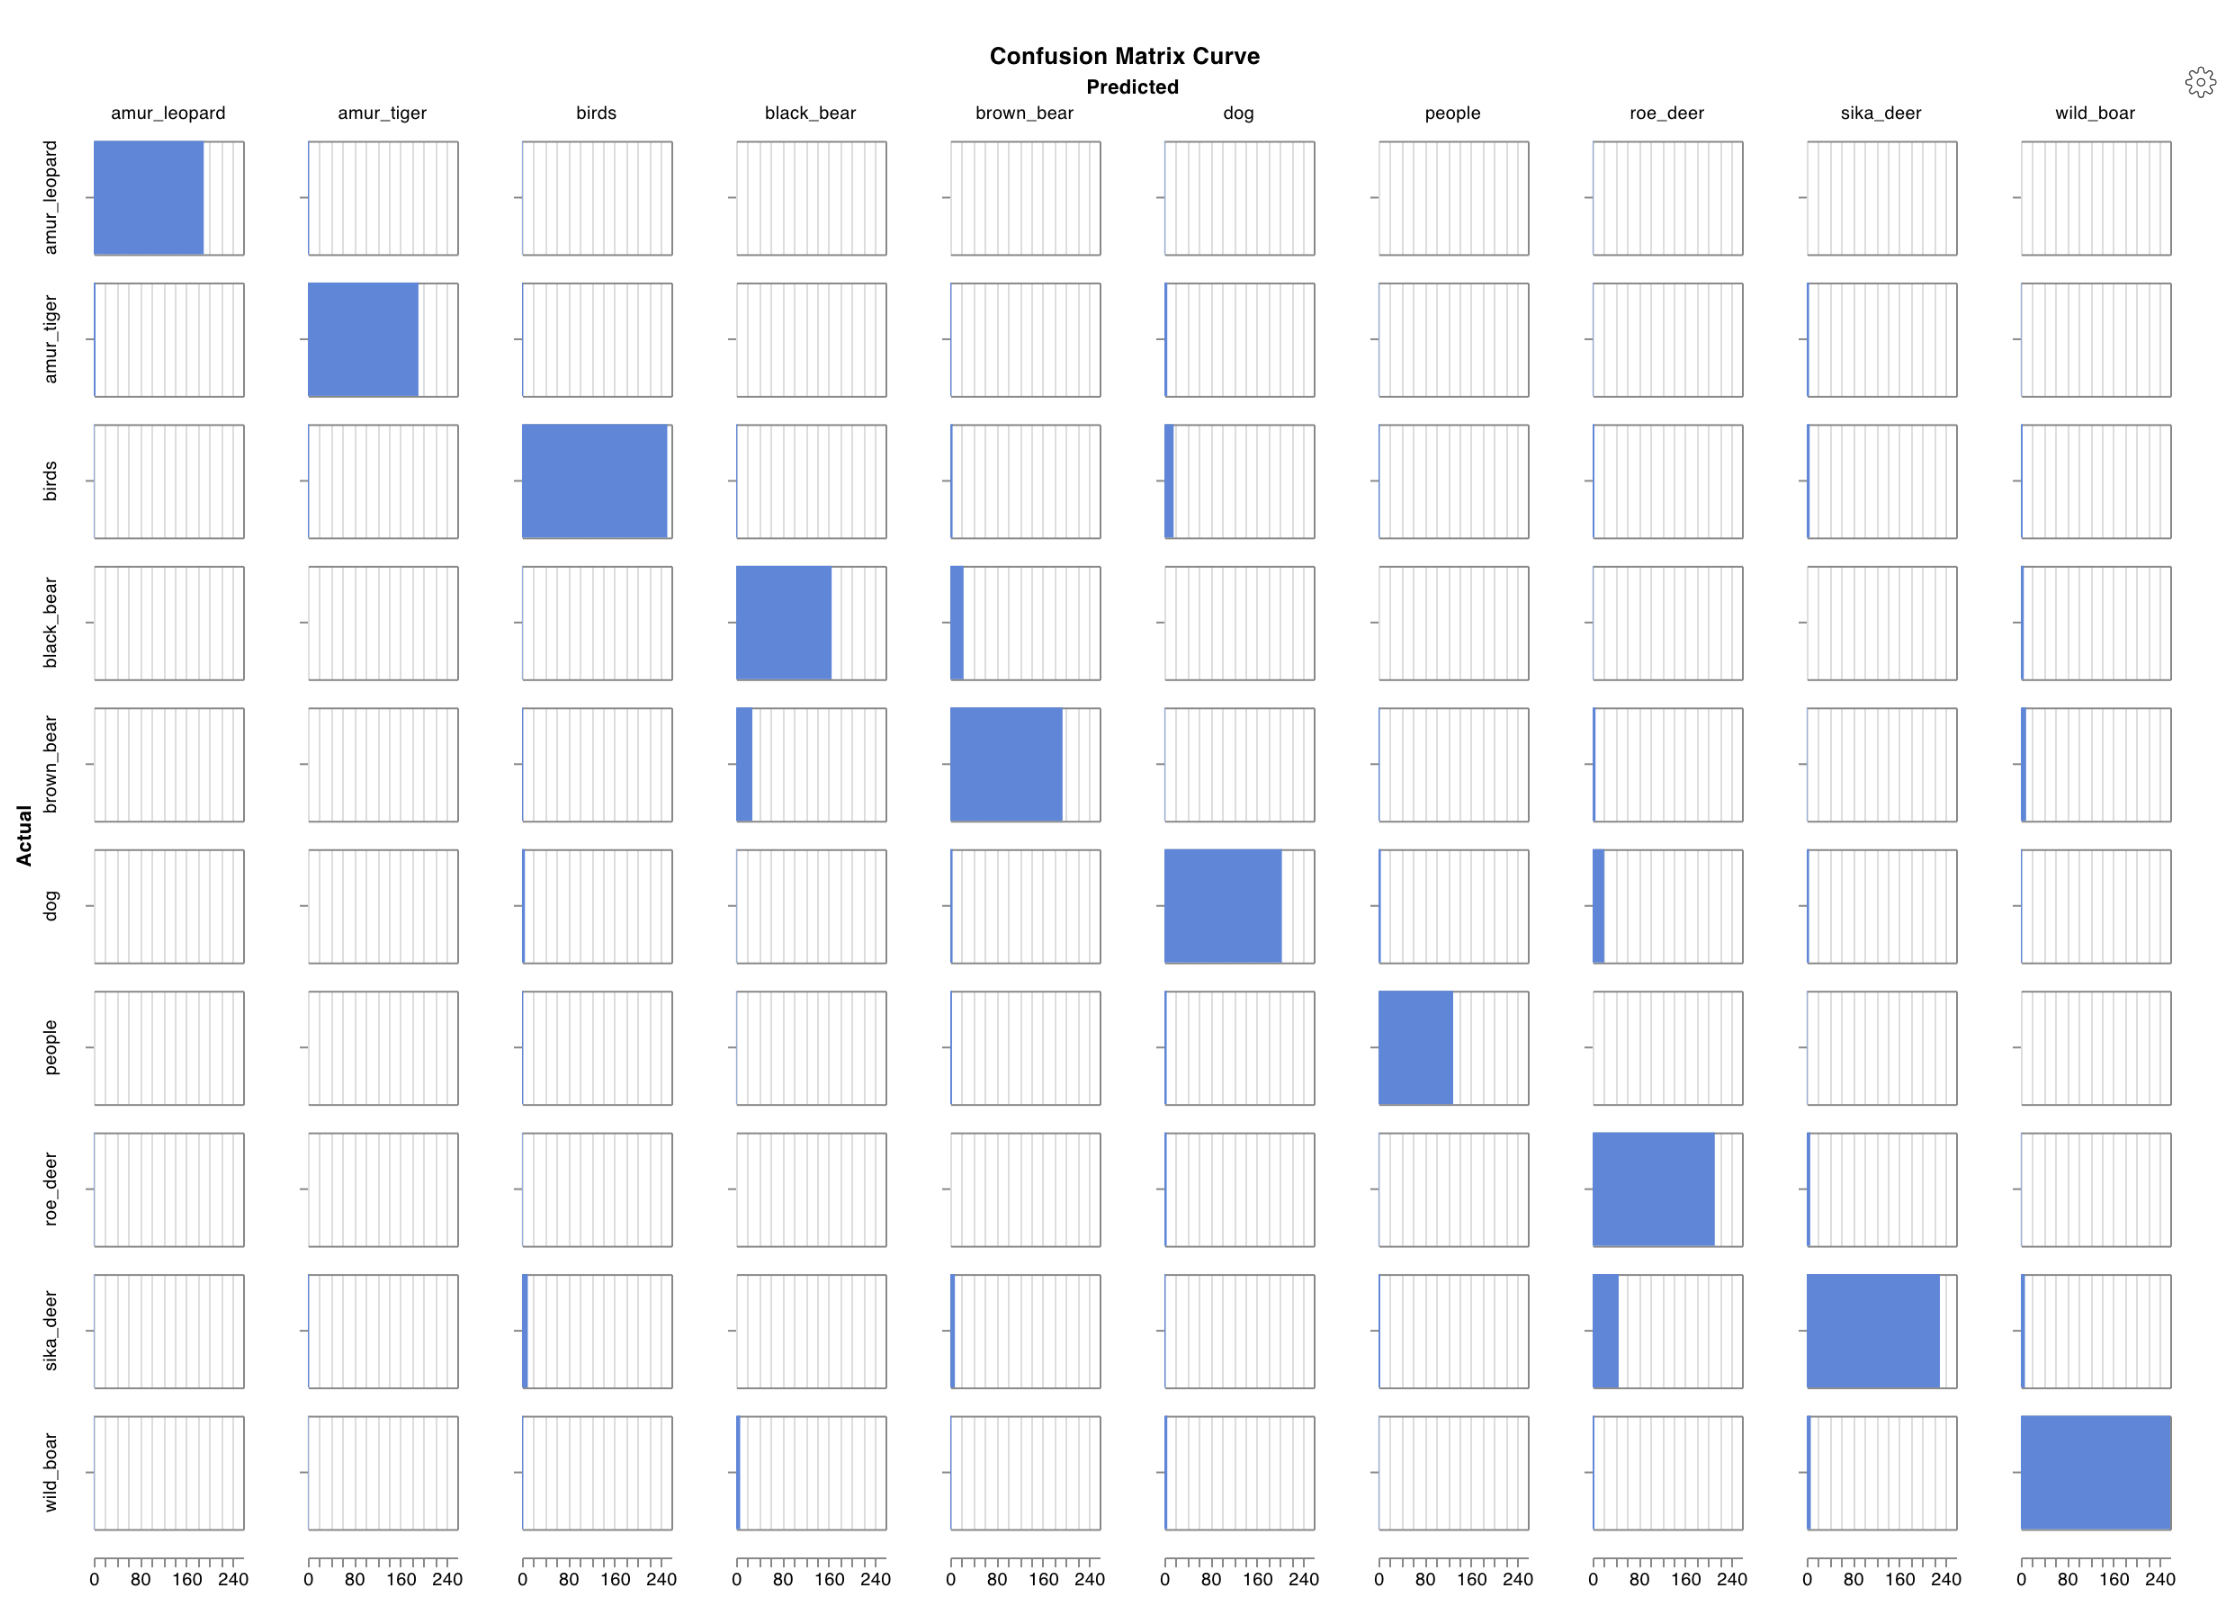

<b> <i> (d) 

In [20]:
backbone = nn.Sequential(*list(resnet18.children())[:-1])  
# This excludes the final 'fc' layer
def extract_features(model, loader, device):
    model.eval()
    features_list = []
    labels_list   = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # get features from penultimate layer
            feat = nn.Sequential(*list(model.children())[:-1])(images)  # shape: [bs, 512, 1, 1]
            feat = feat.view(feat.size(0), -1)  # shape: [bs, 512]
            
            features_list.append(feat.cpu().numpy())
            labels_list.append(labels.numpy())
    
    features = np.concatenate(features_list, axis=0)
    labels   = np.concatenate(labels_list, axis=0)
    return features, labels


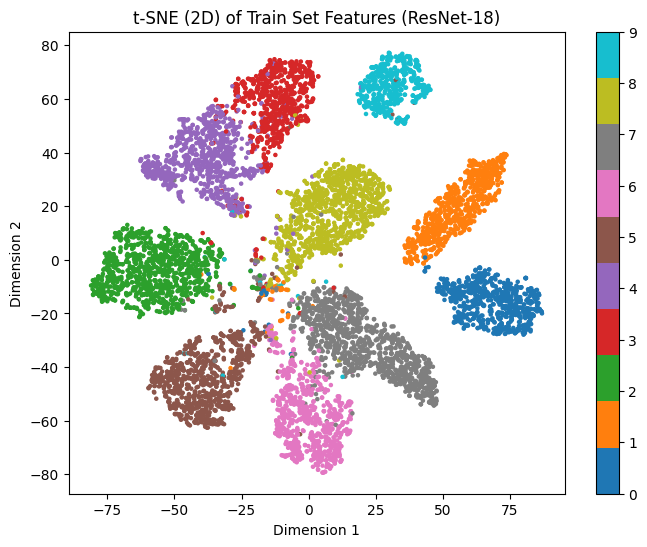

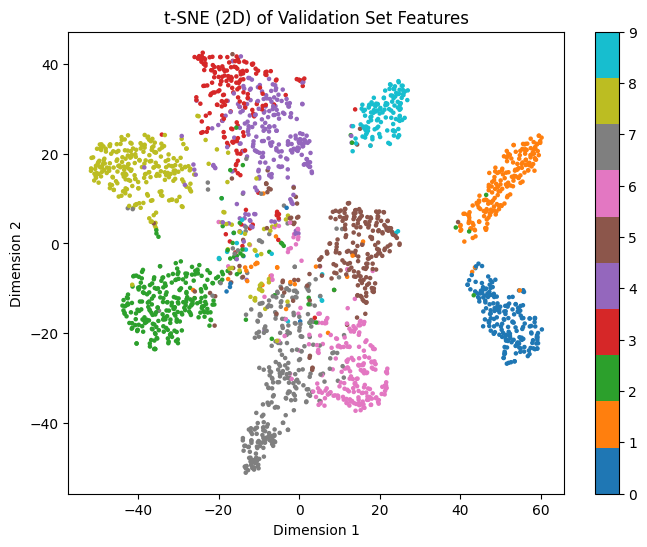

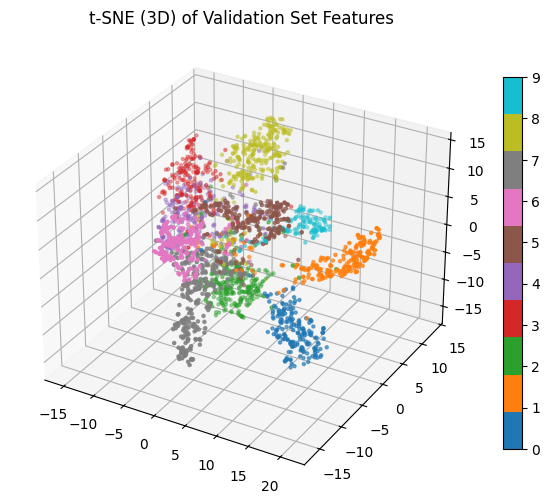

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Extract training features and labels
train_features, train_labels = extract_features(resnet18, train_loader, device)
# 2. Extract validation features and labels
val_features, val_labels = extract_features(resnet18, val_loader, device)

# --- 2D t-SNE for both train and val sets ---
# You might do them separately or combined. 
# Typically, we do them separately if data is large.

# TSNE in 2D (n_components=2)
tsne_2d = TSNE(n_components=2, random_state=42)
train_features_2d = tsne_2d.fit_transform(train_features)

# Then plot color-coded by class
plt.figure(figsize=(8,6))
scatter = plt.scatter(train_features_2d[:,0], train_features_2d[:,1], 
                      c=train_labels, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE (2D) of Train Set Features (ResNet-18)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# Similarly for validation
tsne_2d_val = TSNE(n_components=2, random_state=42)
val_features_2d = tsne_2d_val.fit_transform(val_features)

plt.figure(figsize=(8,6))
scatter_val = plt.scatter(val_features_2d[:,0], val_features_2d[:,1],
                          c=val_labels, cmap='tab10', s=5)
plt.colorbar(scatter_val, ticks=range(10))
plt.title("t-SNE (2D) of Validation Set Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# --- 3D t-SNE for validation set ---
tsne_3d_val = TSNE(n_components=3, random_state=42)
val_features_3d = tsne_3d_val.fit_transform(val_features)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(val_features_3d[:,0], val_features_3d[:,1], val_features_3d[:,2],
               c=val_labels, cmap='tab10', s=5)
fig.colorbar(p, ax=ax, fraction=0.03)
ax.set_title("t-SNE (3D) of Validation Set Features")
plt.show()


<h3> <b> Part 4 : Data augmentation techniques 

<b> <i> (a) 

In [14]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


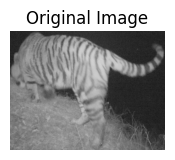

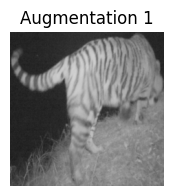

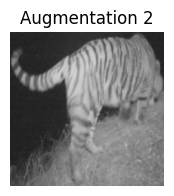

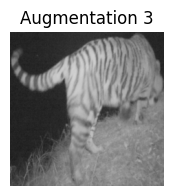

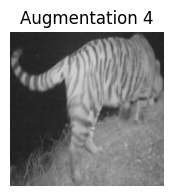

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose you have: train_dataset = RussianWildlifeDataset(train_paths, train_labels, transform=train_transform)

# Grab a single image multiple times to see different augmentations
sample_idx = 0  # index of some training image
original_img_path = train_paths[sample_idx]

# Show the original image
from PIL import Image
original_img = Image.open(original_img_path).convert("RGB")
plt.figure(figsize=(2,2))
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Show 4 augmentations of that same image
for i in range(4):
    # Force the transform
    aug_img_tensor, _ = train_dataset[sample_idx]  # sample_idx always uses transform
    # Convert to a NumPy array for plotting
    aug_img_np = aug_img_tensor.permute(1,2,0).numpy()  # shape (H,W,C)
    # Undo normalization (optional) if you want to display in [0,1] range
    aug_img_np = aug_img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    aug_img_np = np.clip(aug_img_np, 0, 1)

    plt.figure(figsize=(2,2))
    plt.imshow(aug_img_np)
    plt.title(f"Augmentation {i+1}")
    plt.axis("off")
    plt.show()


<b> <i> (b) 

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import wandb

    
# 2. Create Datasets & Dataloaders with the new augmented transform
train_dataset = RussianWildlifeDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = RussianWildlifeDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 3. wandb init, define model, loss, optimizer, etc.
wandb.login()
wandb.init(project="russian-wildlife-augmented", name="cnn_augmented")

resnet18_aug = models.resnet18(pretrained=True)  # or use weights=models.ResNet18_Weights.IMAGENET1K_V1 (newer PyTorch)
num_features = resnet18_aug.fc.in_features

# 2. Modify the final FC layer to match your 10 classes
resnet18_aug.fc = nn.Linear(num_features, 10)

# 3. Decide if you want to fine-tune all layers or only some:
#    By default, if you do *not* freeze anything, all layers are trainable.
#    Example to freeze "early" layers: 
# for name, param in resnet18.named_parameters():
#     if "layer4" not in name and "fc" not in name:
#         param.requires_grad = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet18_aug = resnet18_aug.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_aug.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    resnet18_aug.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = resnet18_aug(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        train_pbar.set_postfix({"loss": f"{running_loss/total:.4f}",
                                "acc": f"{correct/total:.4f}"})
    
    train_epoch_loss = running_loss / total
    train_epoch_acc  = correct / total
    
    # Validation
    resnet18_aug.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            outputs = resnet18_aug(val_images)
            v_loss  = criterion(outputs, val_labels)
            
            val_loss += v_loss.item() * val_labels.size(0)
            _, v_preds = torch.max(outputs, 1)
            val_correct += (v_preds == val_labels).sum().item()
            val_total += val_labels.size(0)
            
    val_epoch_loss = val_loss / val_total
    val_epoch_acc  = val_correct / val_total
    
    wandb.log({
        "epoch": epoch+1,
        "train_loss": train_epoch_loss,
        "train_acc": train_epoch_acc,
        "val_loss": val_epoch_loss,
        "val_acc": val_epoch_acc
    })
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f}, Acc: {train_epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/mnt/drive/home/pragyas/anaconda3/envs/cva1/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/drive/home/pragyas/anaconda3/envs/cva1/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 292/292 [00:29<00:00,  9.91it/s, loss=1.2348, acc=0.5765]


Epoch [1/10] Train Loss: 1.2348, Acc: 0.5765 | Val Loss: 1.0523, Acc: 0.6204


Epoch 2/10: 100%|██████████| 292/292 [00:29<00:00,  9.79it/s, loss=0.8944, acc=0.6923]


Epoch [2/10] Train Loss: 0.8944, Acc: 0.6923 | Val Loss: 0.8140, Acc: 0.7155


Epoch 3/10: 100%|██████████| 292/292 [00:29<00:00,  9.86it/s, loss=0.7669, acc=0.7343]


Epoch [3/10] Train Loss: 0.7669, Acc: 0.7343 | Val Loss: 1.1580, Acc: 0.6740


Epoch 4/10: 100%|██████████| 292/292 [00:30<00:00,  9.69it/s, loss=0.6730, acc=0.7631]


Epoch [4/10] Train Loss: 0.6730, Acc: 0.7631 | Val Loss: 0.8397, Acc: 0.7322


Epoch 5/10: 100%|██████████| 292/292 [00:29<00:00,  9.87it/s, loss=0.6162, acc=0.7841]


Epoch [5/10] Train Loss: 0.6162, Acc: 0.7841 | Val Loss: 0.8035, Acc: 0.7155


Epoch 6/10: 100%|██████████| 292/292 [00:30<00:00,  9.69it/s, loss=0.5566, acc=0.8076]


Epoch [6/10] Train Loss: 0.5566, Acc: 0.8076 | Val Loss: 0.6513, Acc: 0.7781


Epoch 7/10: 100%|██████████| 292/292 [00:31<00:00,  9.20it/s, loss=0.5174, acc=0.8248]


Epoch [7/10] Train Loss: 0.5174, Acc: 0.8248 | Val Loss: 0.5760, Acc: 0.8059


Epoch 8/10: 100%|██████████| 292/292 [00:33<00:00,  8.61it/s, loss=0.4601, acc=0.8369]


Epoch [8/10] Train Loss: 0.4601, Acc: 0.8369 | Val Loss: 0.5936, Acc: 0.7973


Epoch 9/10: 100%|██████████| 292/292 [00:29<00:00,  9.92it/s, loss=0.4439, acc=0.8465]


Epoch [9/10] Train Loss: 0.4439, Acc: 0.8465 | Val Loss: 0.5827, Acc: 0.8063


Epoch 10/10: 100%|██████████| 292/292 [00:33<00:00,  8.81it/s, loss=0.4170, acc=0.8548]


Epoch [10/10] Train Loss: 0.4170, Acc: 0.8548 | Val Loss: 0.5908, Acc: 0.8111


In [18]:
torch.save(resnet18_aug.state_dict(), 'resnet_aug.pth')

<b> <i> (c) 

wandb visualisation:

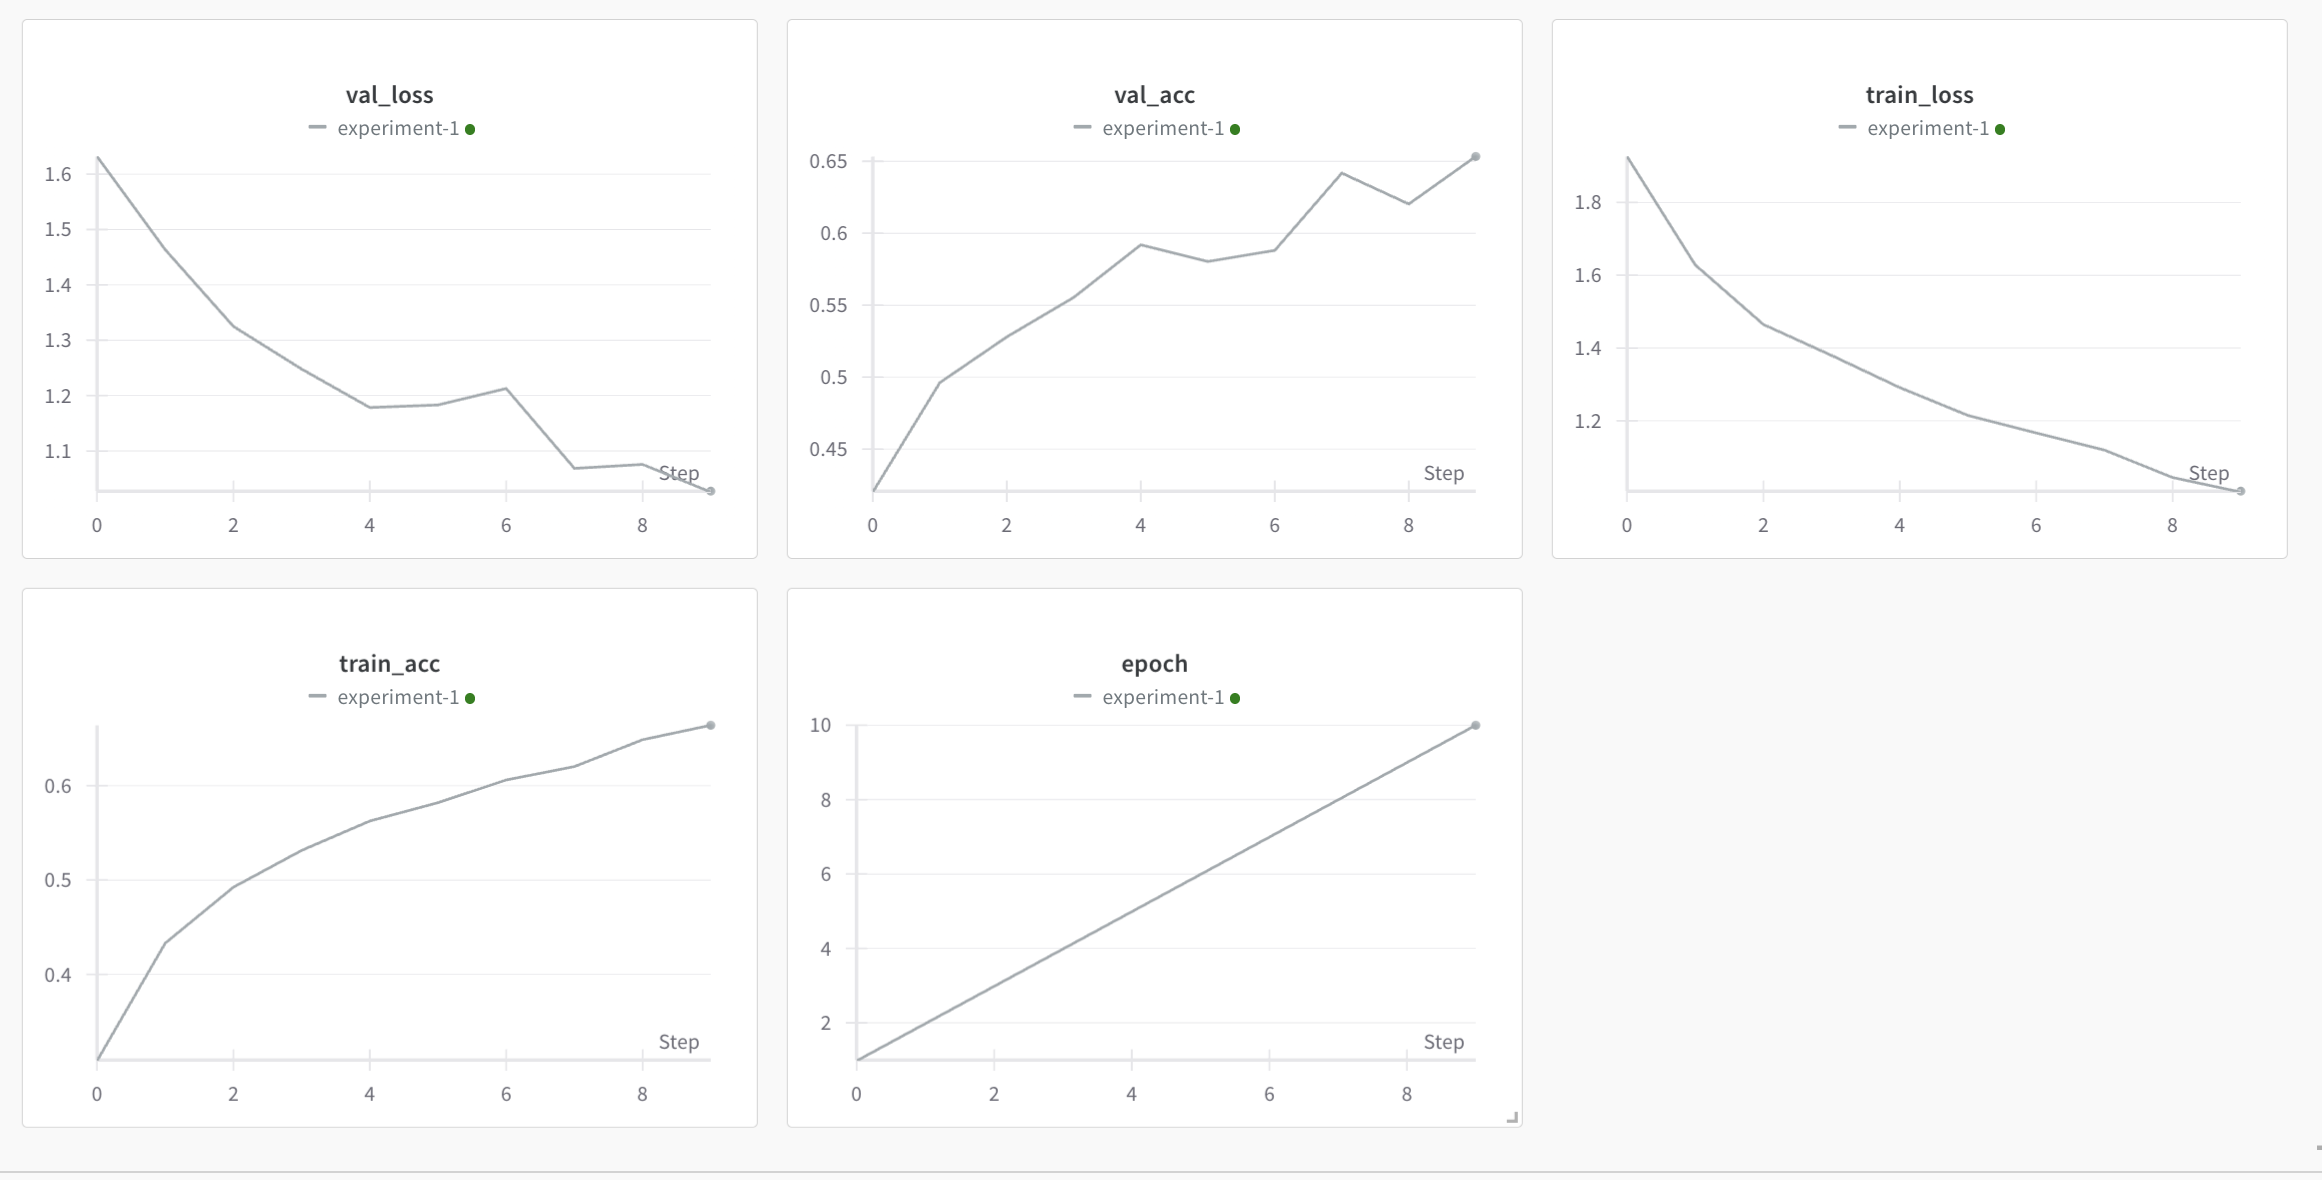

By introducing augmentation (random flip, rotation, color jitter, etc.), the model sees more varied training examples. This usually helps the model generalize better, reducing overfitting. As seen in the new loss plots, the validation loss does not diverge as much, indicating the model is less overfitted compared to before.

<b> <i> (d)

In [21]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

resnet18_aug.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for val_images, val_labels in val_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        
        outputs = resnet18_aug(val_images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(val_labels.cpu().numpy())

val_accuracy = accuracy_score(all_targets, all_preds)
val_f1 = f1_score(all_targets, all_preds, average='macro')
cm = confusion_matrix(all_targets, all_preds)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:\n", cm)

# log to wandb
wandb.log({
    "Final Val Accuracy": val_accuracy,
    "Final Val F1 Score": val_f1
})
wandb.log({
    "confusion_matrix - part 4(d)": wandb.plot.confusion_matrix(
        probs=None,
        y_true=all_targets,
        preds=all_preds,
        class_names=list(label_map.keys())
    )
})

Validation Accuracy: 0.8111
Validation F1 Score: 0.8140
Confusion Matrix:
 [[167   5  19   0   0   0   0   1   3   0]
 [  1 197   4   0   1   2   0   1   3   1]
 [  1   1 266   2   0   8   0   1   4   6]
 [  0   1   6 167  13   3   0   0   5   0]
 [  0   0   8  70 146   2   5   1   9   1]
 [  0   5   9   2   5 195   9   6   8   4]
 [  0   3  12   0   5  15 168  15   6   1]
 [  0   6  26   4   4  19   7 216  19   7]
 [  0   0  14   8   3   3   1   1 255   2]
 [  0   0  14   0   1   6   0   0   3 116]]


wandb:

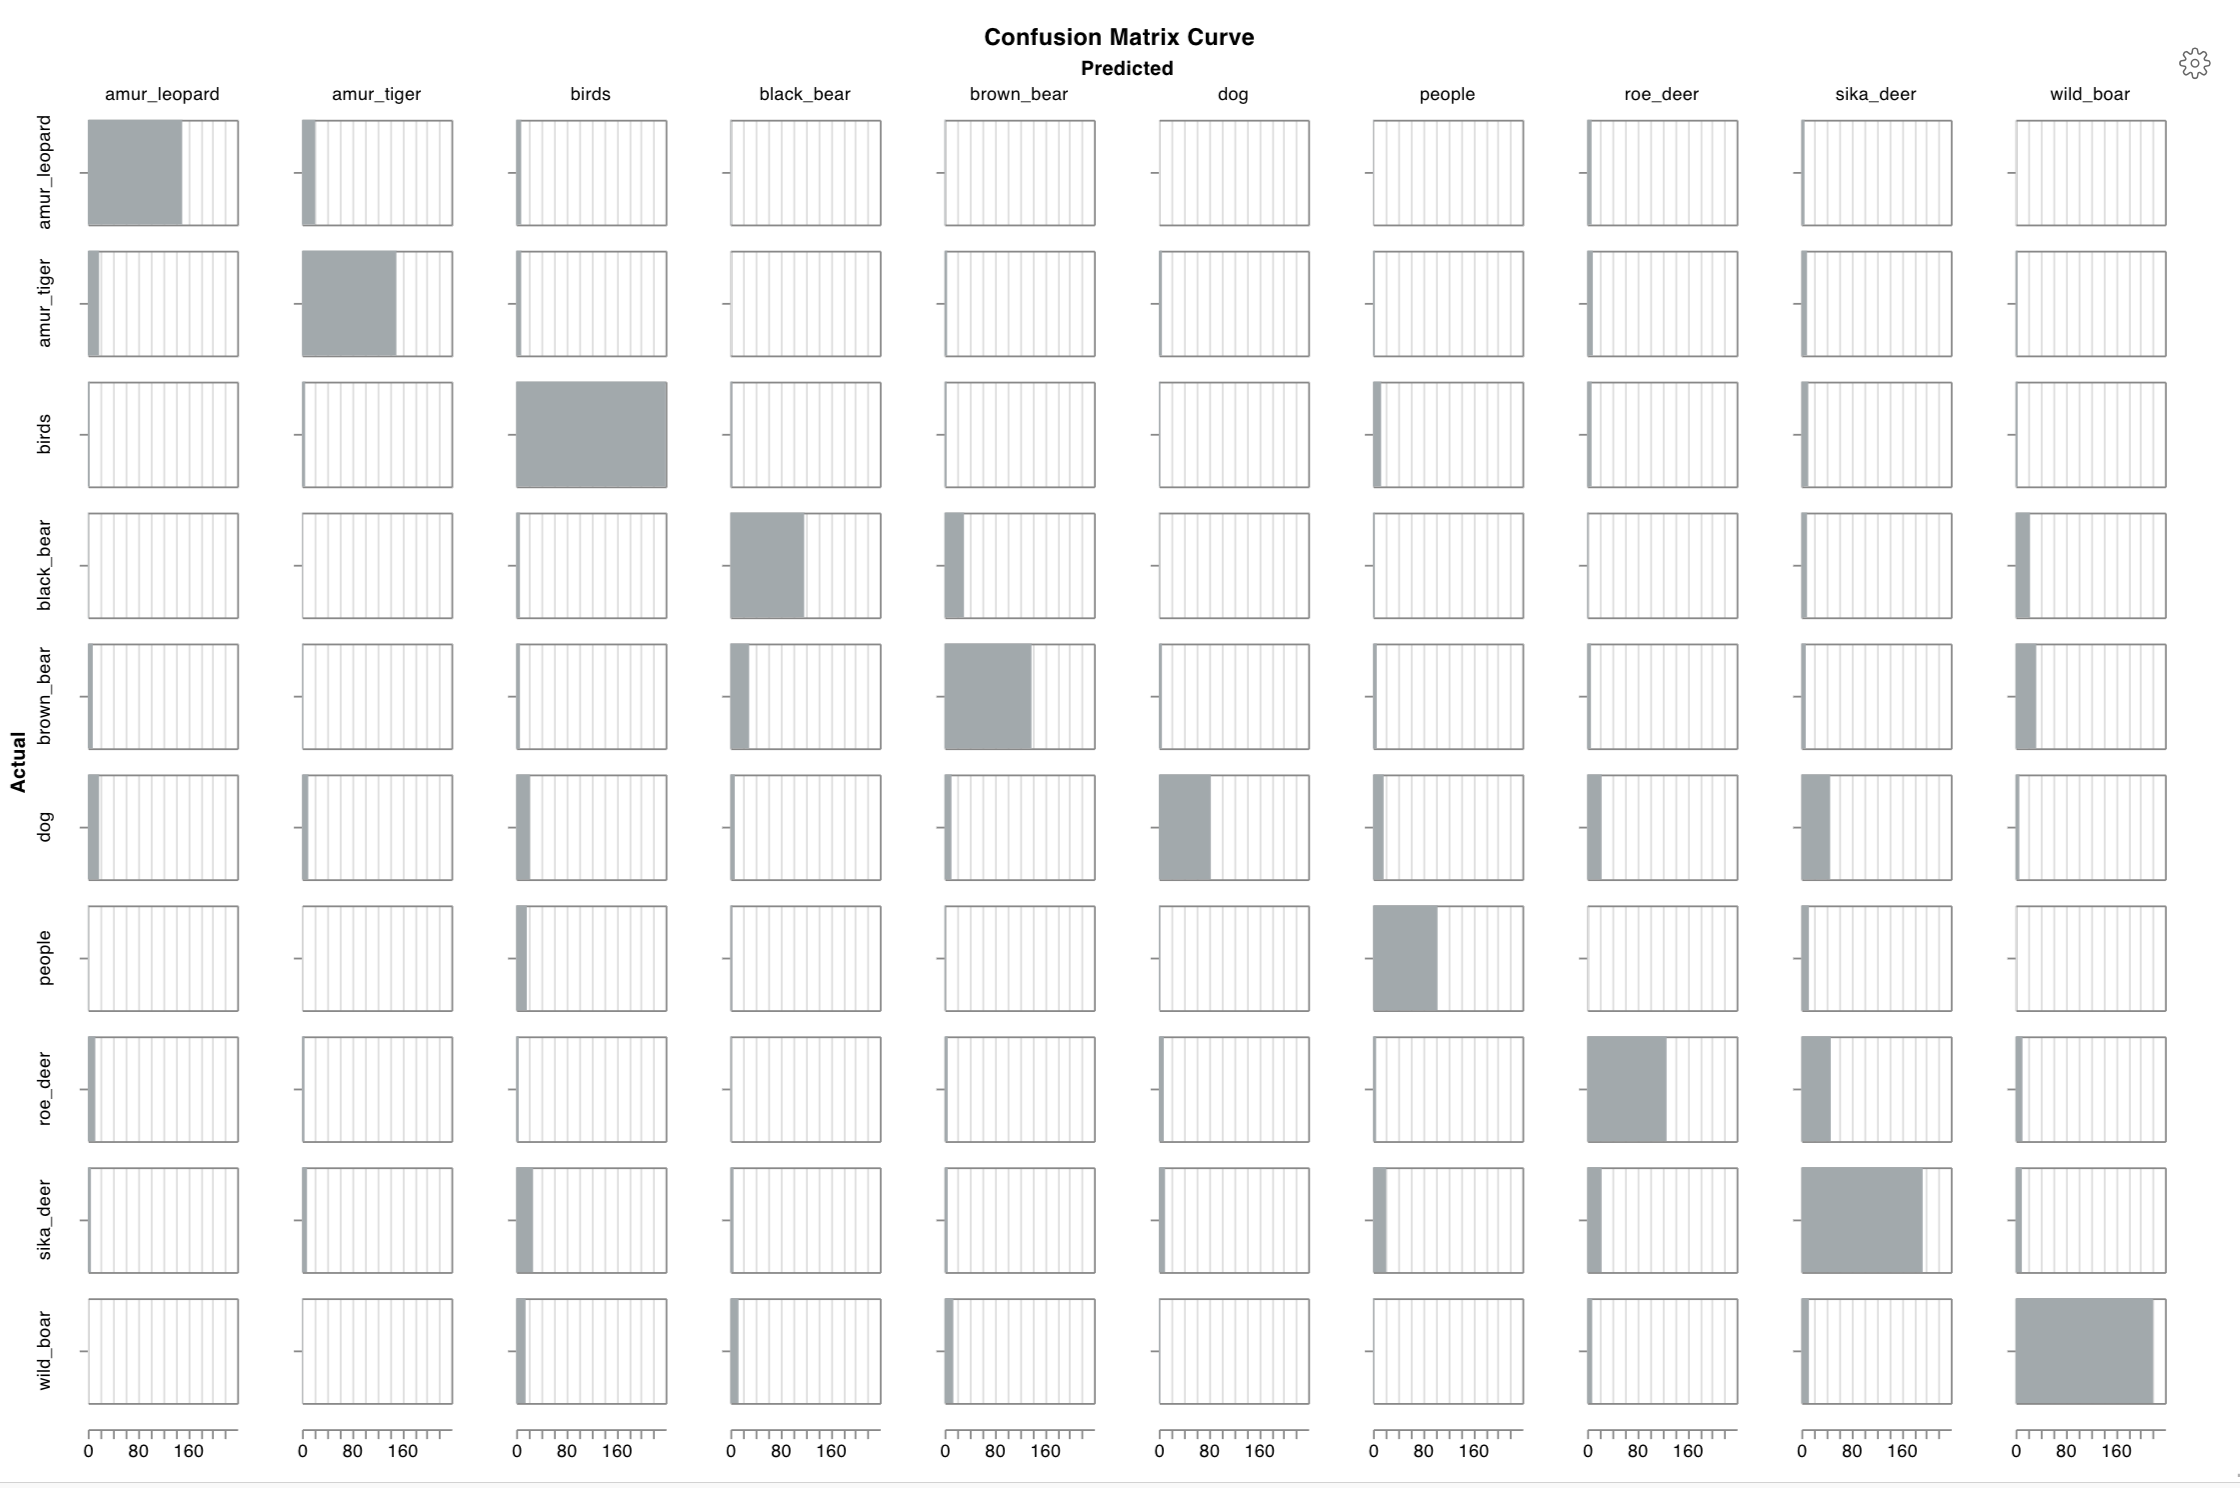

<b> <h3> Part 5

Scratch CNN (Part 2): Achieved ~65% validation accuracy. We noticed some overfitting, as the training accuracy was ~80%.
Fine-tuned ResNet-18 (Part 3): Reached ~76% validation accuracy, training and validation loss both decreased smoothly, less overfitting was observed, thanks to pretrained features.
Scratch CNN with Augmentation (Part 4): Ended up at ~84% validation accuracy, which is better than the non-augmented resnet18 model. The gap between training and validation accuracy also shrank, indicating reduced overfitting.